<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import torch.optim as optim
import torchvision.transforms as transforms

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [42]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [43]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Думаю, что чем больше batch-size, тем быстрее обуяается модель, и наоборот. Чем больше батч сайз - тем на меньшее количество групп мы делим датасет и соответственно меньшее колияество раз обновляем веса модели.

Посмотрим на какую-нибудь картинку:

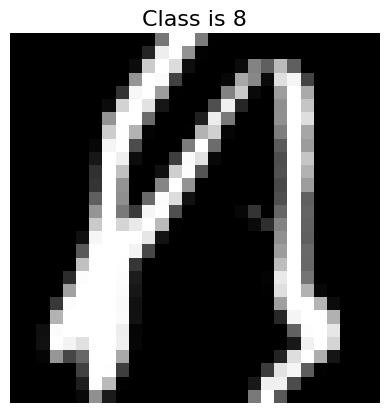

In [44]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [45]:
trainset.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

In [46]:
class_indices = {'o': 0, 'ki': 1, 'su': 2, 'tsu': 3, 'na': 4, 'ha': 5, 'ma': 6, 'ya': 7, 're': 8, 'wo': 9}
representatives = {class_name: None for class_name in class_indices.keys()}

for image, label in trainset:
    class_name = trainset.classes[label]
    if class_name in representatives and representatives[class_name] is None:
        representatives[class_name] = image

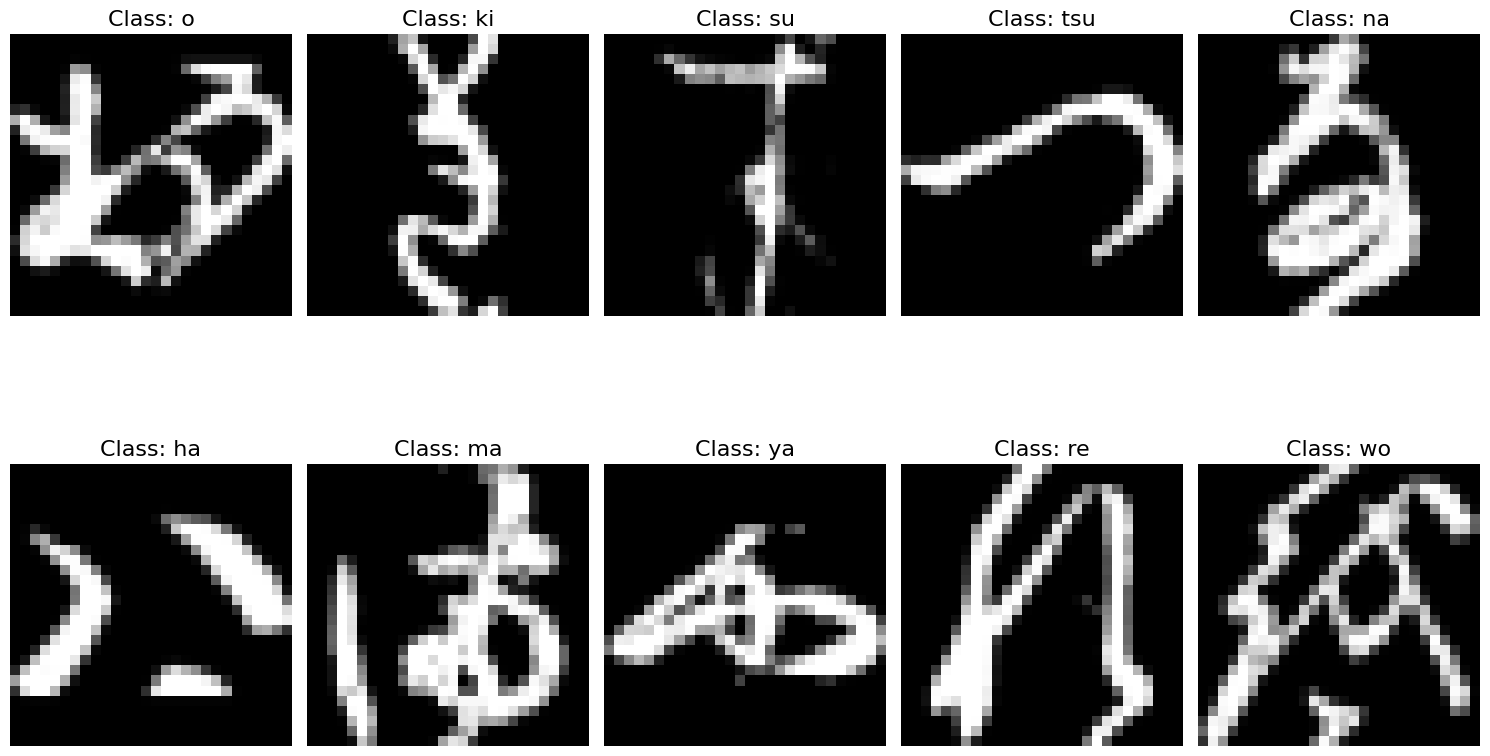

In [47]:
plt.figure(figsize=(15, 10))

for i, (class_name, image) in enumerate(representatives.items(), 1):
    plt.subplot(2, 5, i)
    plt.imshow(image.view(28, 28).numpy(), cmap="gray")
    plt.axis("off")
    plt.title(f"Class: {class_name}", fontsize=16)

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [48]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__() #  это надо помнить!
        self.num_classes = num_classes
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)
        


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** В первом слое 784*256+256=200960 весов+смещения, во втором слое 256*128+128=32896, в третьем слое 128*10+10=1290. Итого 200960+32896+1290=235146.

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [49]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [25]:
# Создадим объект модели
fc_net = FCNet(num_classes=10)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [26]:
%%time

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")

Epoch=1, Loss=0.9157
Epoch=2, Loss=0.4408
Epoch=3, Loss=0.3457
Epoch=4, Loss=0.2911
Epoch=5, Loss=0.2504
Epoch=6, Loss=0.2182
Epoch=7, Loss=0.1927
Epoch=8, Loss=0.1689
Epoch=9, Loss=0.1502
Epoch=10, Loss=0.1331
CPU times: user 18.4 s, sys: 1min 2s, total: 1min 20s
Wall time: 40.8 s


In [27]:
get_accuracy(fc_net, testloader)

0.869

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [28]:
to_tensor = transforms.ToTensor()
all_pixel_values = []

for images, _ in trainset:
    all_pixel_values.append(images)
    
all_pixel_values = torch.stack(all_pixel_values)
mean = all_pixel_values.mean()
std = all_pixel_values.std()
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [29]:
fc_net = FCNet(num_classes=10)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [30]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")


Epoch=1, Loss=0.6857
Epoch=2, Loss=0.2998
Epoch=3, Loss=0.2195
Epoch=4, Loss=0.1708
Epoch=5, Loss=0.1369
Epoch=6, Loss=0.1120
Epoch=7, Loss=0.0915
Epoch=8, Loss=0.0758
Epoch=9, Loss=0.0622
Epoch=10, Loss=0.0508


In [31]:
get_accuracy(fc_net, testloader)

0.8975

Как изменилась `accuracy` после нормализации?

Прям выросла! Я в восторге.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [50]:
class FCNet(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        if activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'gelu':
            self.activation = F.gelu
        elif activation == 'tanh':
            self.activation = torch.tanh
        else:
            self.activation = F.relu

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)
        return logits


In [66]:
class FCNet(nn.Module):
    def __init__(self, num_classes=10, activation='relu'):
        super().__init__() #  это надо помнить!
        self.num_classes = num_classes
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)
        
        if activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'gelu':
            self.activation = F.gelu
        elif activation == 'tanh':
            self.activation = torch.tanh
        else:
            self.activation = F.relu
        


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)

        return logits

In [34]:
model_sigmoid = FCNet(activation='sigmoid')
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_sigmoid.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_sigmoid(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")

Epoch=1, Loss=0.6837
Epoch=2, Loss=0.3064
Epoch=3, Loss=0.2246
Epoch=4, Loss=0.1749
Epoch=5, Loss=0.1392
Epoch=6, Loss=0.1119
Epoch=7, Loss=0.0922
Epoch=8, Loss=0.0754
Epoch=9, Loss=0.0617
Epoch=10, Loss=0.0496


In [35]:
model_gelu = FCNet(activation='gelu')
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_gelu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_gelu(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")

Epoch=1, Loss=0.6891
Epoch=2, Loss=0.3032
Epoch=3, Loss=0.2247
Epoch=4, Loss=0.1751
Epoch=5, Loss=0.1396
Epoch=6, Loss=0.1130
Epoch=7, Loss=0.0920
Epoch=8, Loss=0.0764
Epoch=9, Loss=0.0626
Epoch=10, Loss=0.0507


In [36]:
model_tahn = FCNet(activation='tahn')
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_tahn.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_tahn(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")

Epoch=1, Loss=0.6881
Epoch=2, Loss=0.3005
Epoch=3, Loss=0.2238
Epoch=4, Loss=0.1762
Epoch=5, Loss=0.1410
Epoch=6, Loss=0.1168
Epoch=7, Loss=0.0946
Epoch=8, Loss=0.0782
Epoch=9, Loss=0.0639
Epoch=10, Loss=0.0530


In [37]:
model_relu = FCNet(activation='relu')
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_relu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_relu(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Epoch={epoch+1}, Loss={average_loss:.4f}")

Epoch=1, Loss=0.6878
Epoch=2, Loss=0.3006
Epoch=3, Loss=0.2209
Epoch=4, Loss=0.1720
Epoch=5, Loss=0.1381
Epoch=6, Loss=0.1118
Epoch=7, Loss=0.0902
Epoch=8, Loss=0.0751
Epoch=9, Loss=0.0608
Epoch=10, Loss=0.0493


In [38]:
print(f'Relu model accuracy = {get_accuracy(model_relu, testloader)}')
print(f'Sigmoid model accuracy = {get_accuracy(model_sigmoid, testloader)}')
print(f'Gelu model accuracy = {get_accuracy(model_gelu, testloader)}')
print(f'Tahn model accuracy = {get_accuracy(model_tahn, testloader)}')

Relu model accuracy = 0.9024
Sigmoid model accuracy = 0.8958
Gelu model accuracy = 0.8988
Tahn model accuracy = 0.892


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Лучше всего отработала relu, но вообще если нессколько раз перезапускать, то скоры могут немного меняться, поэтому я бы не сказала, что она стат значимо лучше:)

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [52]:
model_relu_adam = FCNet(activation='relu')
loss_function = nn.CrossEntropyLoss()

adam_optimizer = optim.Adam(model_relu_adam.parameters(), lr=0.001)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        adam_optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_relu_adam(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        adam_optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Adam Epoch={epoch+1}, Loss={average_loss:.4f}")
    

Adam Epoch=1, Loss=0.6138
Adam Epoch=2, Loss=0.2844
Adam Epoch=3, Loss=0.1958
Adam Epoch=4, Loss=0.1436
Adam Epoch=5, Loss=0.1096
Adam Epoch=6, Loss=0.0824
Adam Epoch=7, Loss=0.0634
Adam Epoch=8, Loss=0.0494
Adam Epoch=9, Loss=0.0353
Adam Epoch=10, Loss=0.0264


In [54]:
model_relu_rms = FCNet(activation='relu')
loss_function = nn.CrossEntropyLoss()

rmsprop_optimizer = optim.RMSprop(model_relu_rms.parameters(), lr=0.001)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        rmsprop_optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_relu_rms(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        rmsprop_optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"RMSprop Epoch={epoch+1}, Loss={average_loss:.4f}")

RMSprop Epoch=1, Loss=0.4779
RMSprop Epoch=2, Loss=0.2142
RMSprop Epoch=3, Loss=0.1453
RMSprop Epoch=4, Loss=0.1029
RMSprop Epoch=5, Loss=0.0761
RMSprop Epoch=6, Loss=0.0549
RMSprop Epoch=7, Loss=0.0406
RMSprop Epoch=8, Loss=0.0299
RMSprop Epoch=9, Loss=0.0235
RMSprop Epoch=10, Loss=0.0169


In [57]:
model_relu_ada = FCNet(activation='relu')
loss_function = nn.CrossEntropyLoss()

adagrad_optimizer = optim.Adagrad(model_relu_ada.parameters(), lr=0.001)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        adagrad_optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_relu_ada(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        adagrad_optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)

    print(f"Adagrad Epoch={epoch+1}, Loss={average_loss:.4f}")

Adagrad Epoch=1, Loss=1.0393
Adagrad Epoch=2, Loss=0.6578
Adagrad Epoch=3, Loss=0.5838
Adagrad Epoch=4, Loss=0.5427
Adagrad Epoch=5, Loss=0.5154
Adagrad Epoch=6, Loss=0.4952
Adagrad Epoch=7, Loss=0.4786
Adagrad Epoch=8, Loss=0.4649
Adagrad Epoch=9, Loss=0.4525
Adagrad Epoch=10, Loss=0.4424


In [58]:
print(f'Adam model accuracy = {get_accuracy(model_relu_adam, testloader)}')
print(f'RMSprop model accuracy = {get_accuracy(model_relu_rms, testloader)}')
print(f'Adagrad model accuracy = {get_accuracy(model_relu_ada, testloader)}')

Adam model accuracy = 0.8993
RMSprop model accuracy = 0.8686
Adagrad model accuracy = 0.7471


Лучше всего работает adam.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [78]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [75]:
class FCNetCustomRelU(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(784, 256) 
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = CustomReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)
        return logits


In [76]:
model_relu = FCNet(activation='relu')
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_relu.parameters(), lr=0.001)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:  # Получаем батч тренировочных картинок
        optimizer.zero_grad()  # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = model_relu(images)  # делаем предсказания
        loss = loss_function(outputs, labels)  # считаем лосс
        loss.backward()  # считаем градиенты
        optimizer.step()  # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)
    loss_history.append(average_loss)
    
    print(f"ReLU model Epoch={epoch+1}, Loss={average_loss:.4f}")

ReLU model Epoch=1, Loss=0.6172
ReLU model Epoch=2, Loss=0.2753
ReLU model Epoch=3, Loss=0.1944
ReLU model Epoch=4, Loss=0.1423
ReLU model Epoch=5, Loss=0.1075
ReLU model Epoch=6, Loss=0.0802
ReLU model Epoch=7, Loss=0.0625
ReLU model Epoch=8, Loss=0.0464
ReLU model Epoch=9, Loss=0.0336
ReLU model Epoch=10, Loss=0.0260


In [79]:
model_relu_custom = FCNetCustomRelU()  
model_relu.load_state_dict(model_relu.state_dict()) # pretrained

model_relu_custom.fc1 = nn.Linear(784, 256)
model_relu_custom.fc2 = nn.Linear(256, 128)
model_relu_custom.fc3 = nn.Linear(128, 10)
model_relu_custom.activation = CustomReLU()


with torch.no_grad():
    model_relu_output = model_relu(images)
    model_relu_custom_output = model_relu_custom(images)

outputs_equal = torch.allclose(model_relu_output, model_relu_custom_output)
if outputs_equal:
    print("Outputs are the same. CustomReLU is True.")
else:
    print("Outputs are different. CustomReLU is False.")

Outputs are different. CustomReLU is False.


Я не понимаю почему:(

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Я использовала GigaChat (Kandinsky 2.2) для генерации картинок и своих троих разносторонних друзей для генерации текста.

In [80]:
from IPython.display import Image

Пыльная грунтовая дорога с ямами


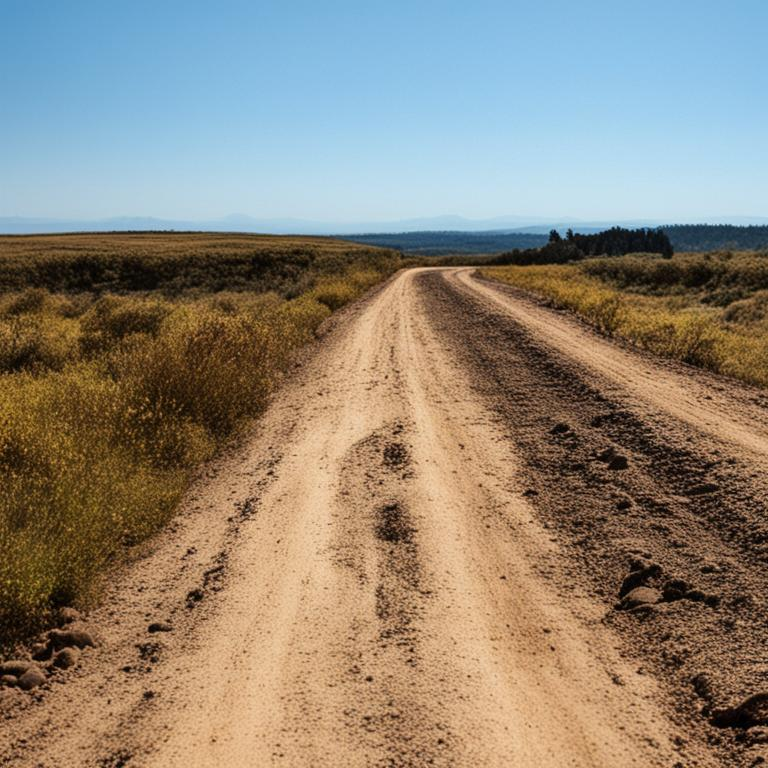

In [81]:
print('Пыльная грунтовая дорога с ямами')
Image("IMG_2996.JPG", width=320, height=240)

Котик, сидящий на цветущей сакуре


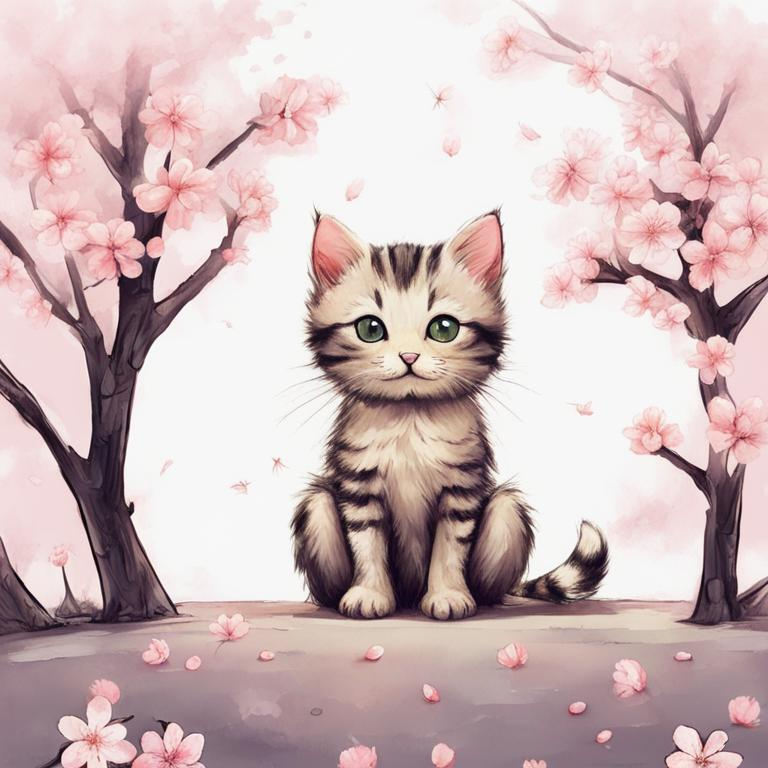

In [82]:
print('Котик, сидящий на цветущей сакуре')
Image("IMG_2997.JPG", width=320, height=240)

Митохондрия производит энергию для клетки


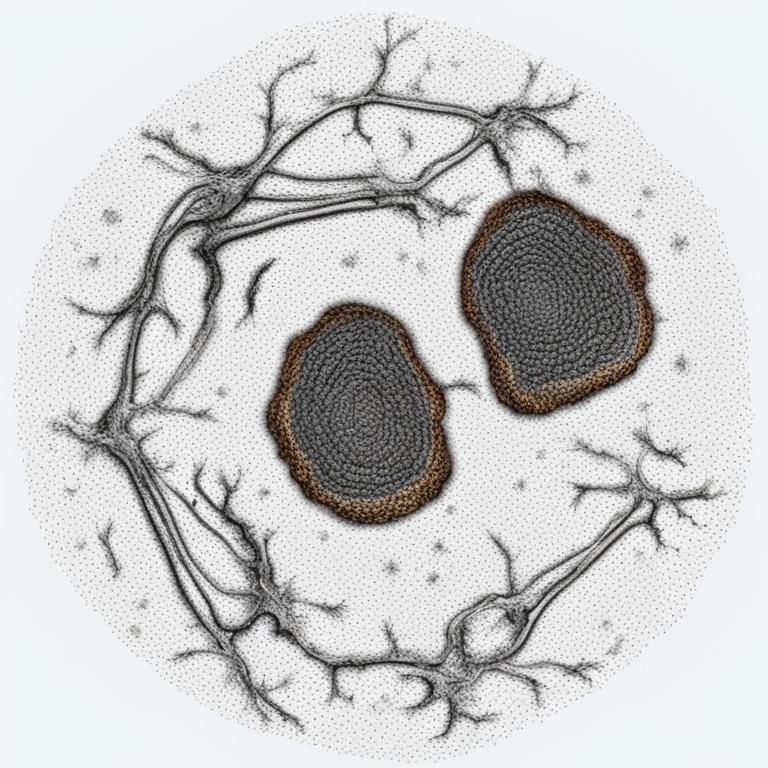

In [83]:
print('Митохондрия производит энергию для клетки')
Image("IMG_2998.JPG", width=320, height=240)